# Dealing with Noise

Taking derivatives is particularly challenging in the presence of noise, because the peaky, pointy nature of random variations can cause dramamtic local deviations of function slope. Let's start with some theory.

In [1]:
import json, pandas, numpy as np
from numpy.polynomial import Polynomial as poly
from collections import deque
from matplotlib import pyplot
from scipy.fft import dct, dst
#from scipy.signal import savgol_filter, butter, sosfilt # experimented with some hybrids
from pynumdiff import savgoldiff
from IPython.display import HTML, display

import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv, fourier_deriv
with open('alternative_chebyshev_derivative_methods.ipynb', 'r') as f: # Hacky but effective way to load code from another notebook
	notebook = json.load(f)
for cell in notebook['cells']:
	if cell['cell_type'] == 'code' and cell['source'][0].startswith('def cheb_deriv_via_fourier('):
		exec(''.join(cell['source']))
		break
def collapsible_text(text, label): # Handy function DeepSeek made for me, because my printouts were getting silly
    display(HTML(f"""<details><summary style="cursor: pointer; color: blue;">{label}</summary><pre>{text}</pre></details>"""))


## Noise and Signal are Typically Frequency-Separable

This is the central dogma that allows us to address noise across signal processing.

> "Every spectrum of real noise falls off reasonably rapidly as you go to infinite frequencies, or else it would have infinite energy. But the sampling process aliases higher frequencies in lower ones, and the folding ... tends to produce a flat specturm. ... *white noise*. The signal, usually, is mainly in the lower frequencies."  
–Richard Hamming, *The Art of Doing Science and Engineering*, Digital Filters III

We expect our sampling rate to be fast enough to capture fluctuations of interest in the data, e.g. the Nyquist rate (2x the highest frequency of interest in the data), so most signal energy is expressed by relatively low frequencies. Noise shows up at all frequencies, but the more we sample, the more we can distribute its energy across frequencies, hopefully putting most of its mass at *higher frequency* than the data. Thus we can separate data from noise in the frequency domain!

*All noise reduction methods are at bottom low-pass filters*: averaging, Kalman filtering, etc.

## Spectral Filtering's Connection to Error Correcting Codes

Because a spectral representation builds a function out of basis functions that span the entire domain, every point's value takes the entire domain under consideration. This makes the reconstruction much more *robust* to perturbations than one that uses only a few neighboring points. I.e. it's much harder to *corrupt* the signal so thoroughly that it can't be successfully recovered.

This has an analog to [error-correcting codes](https://www.youtube.com/watch?v=X8jsijhllIA), except that in the context of continuous signals, "corruption" means (discrete representations of) continous numbers have slightly inaccurate values, whereas in error correcting codes each datum is a *single discrete bit* which can simply be *flipped*. But notice the bits corresponding to each subsequent parity check of a Hamming Code correspond to "higher-frequency" selections:

<img src="hamming.png" width=500 />

From *The Art of Doing Science and Engineering* again, with my drawings in the margins.

In a spectral method, the coefficients say "You need to add in this much of the $k^{th}$ basis function", but in error correcting codes the analogous parity checks say "There is/isn't a parity error among my bits." In both cases a spot-corruption will stand out, because it appears in a particular combination of parity checks or introduces a value that can't be as easily/smoothly represented with a finite combination of basis functions.

## Types of Noise

Noise can have a couple different sources. If noise is due to imperfect sensing, then each sample is drawn from its own little Gaussian. By contrast, if there is uncertainty in the underlying dynamics, then we might say there is noise in the process itself. If we sample our signal uniformly, as we do when using the Fourier basis and most other filtering methods, since they tend to be [more computationally expensive to generalize to non-uniform samplings](https://dsp.stackexchange.com/questions/1676/savitzky-golay-smoothing-filter-for-not-equally-spaced-data), then we don't really need to make a distinction between these noise sources, because they look the same. But if we cosine-sample our data as we probably want to for expediency when using the Chebyshev basis, there will be a difference.

### Measurement Noise

At equispaced points, as we use with the Fourier basis to achieve $O(N \log N)$ frequency transform, noise across measurements will look something like this:

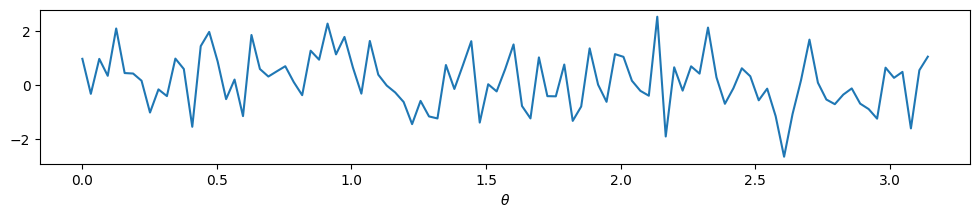

In [2]:
N = 100
noise = np.random.randn(N+1)

pyplot.figure(figsize=(12,2))
pyplot.plot((np.arange(N+1) * np.pi / N), noise)
pyplot.xlabel(r"$\theta$");

But in the case of measurement noise at cosine-spaced points, our noise wave will look something like the following in the $x$ domain (left-right inverted below to match the above), with noise spread out in the middle and squished at the edges:

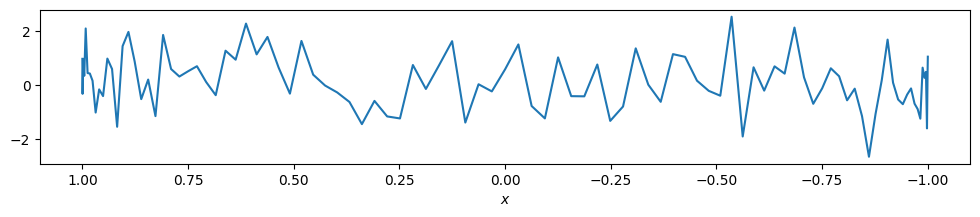

In [3]:
pyplot.figure(figsize=(12,2))
pyplot.plot(np.cos(np.arange(N+1) * np.pi / N), noise)
pyplot.gca().invert_xaxis()
pyplot.xlabel(r"$x$");

Toward the edges of the domain as $\Delta x$ decreases while the $\Delta y$ of noise is undiminished, there will be higher frequencies in the noise, and the error in $\frac{\Delta y}{\Delta x}$ will increase dramatically, a fundamental limitation of Chebyshev-based methods.

This is perhaps best shown mathematically in the [Chebyshev-via-Fourier method](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/alternative_chebyshev_derivative_methods.ipynb), where we not only implicitly *warp* the function to be $y(\cos(\theta))$ by taking a DCT (thereby treating measurement noise as if it's evenly distributed in the $\theta$ domain), but we later also explicitly *unwarp* to get back to the $x$ domain, involving division by powers of [$\sqrt{1-x^2}$](https://pavelkomarov.com/spectral-derivatives/math.pdf), which $ \rightarrow 0$ as $x \rightarrow \pm 1$.

### Process Noise

In this case we expect the noise to look evenly-distributed across whichever domain and simply *be sampled* at different points. Sampling at cosine-spaced points (for both DCT-I and DCT-II) looks like:

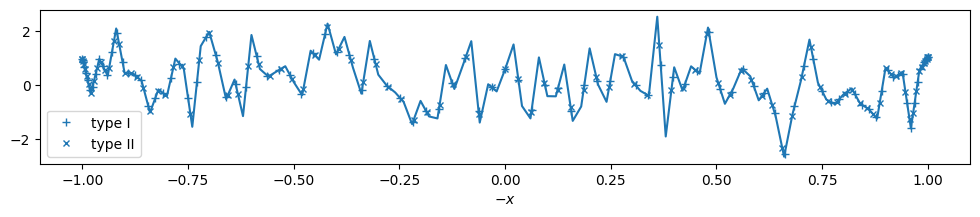

In [4]:
def cos_spaced_from_equi(y_n):
    """Interpolate the vector y_n, which is linspaced on [-1, 1], to find values at cosine-spaced points"""
    N = len(y_n) - 1
    x_lin = np.linspace(-1, 1, N+1)
    dx = x_lin[1] - x_lin[0]
    
    x_cos = np.cos(np.arange(N+1) * np.pi / N)
    i = 0
    c_n = []
    for x_n in x_cos[::-1]: # iterate low to high to fit my intuition
        while not x_lin[i] <= x_n <= x_lin[i+1]:
            i += 1
        c_n.append( ((x_n - x_lin[i]) * y_n[i+1] + (x_lin[i+1] - x_n) * y_n[i])/dx )

    x_cos2 = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))
    i = 0
    c_n2 = []
    for x_n2 in x_cos2[::-1]: # iterate low to high to fit my intuition
        while not x_lin[i] <= x_n2 <= x_lin[i+1]:
            i += 1
        c_n2.append( ((x_n2 - x_lin[i]) * y_n[i+1] + (x_lin[i+1] - x_n2) * y_n[i])/dx )
        
    return np.array(c_n[::-1]), x_cos, np.array(c_n2[::-1]), x_cos2

cos_noise, x_cos, cos_noise2, x_cos2 = cos_spaced_from_equi(noise)
pyplot.figure(figsize=(12,2))
pyplot.plot(np.linspace(-1, 1, len(noise)), noise)
pyplot.plot(x_cos, cos_noise, 'C0+', label='type I');
pyplot.plot(x_cos2, cos_noise2, 'C0x', ms=5, label='type II')
pyplot.xlabel(r"$-x$")
pyplot.legend();

With this scheme, noise samples at the tightly-packed endpoints are no longer as statistically independent as noise samples in the spaced-out middle.

If we consider what this looks like in the implicit $\theta$ domain, we get a squish in the middle and spreading out at the edges:

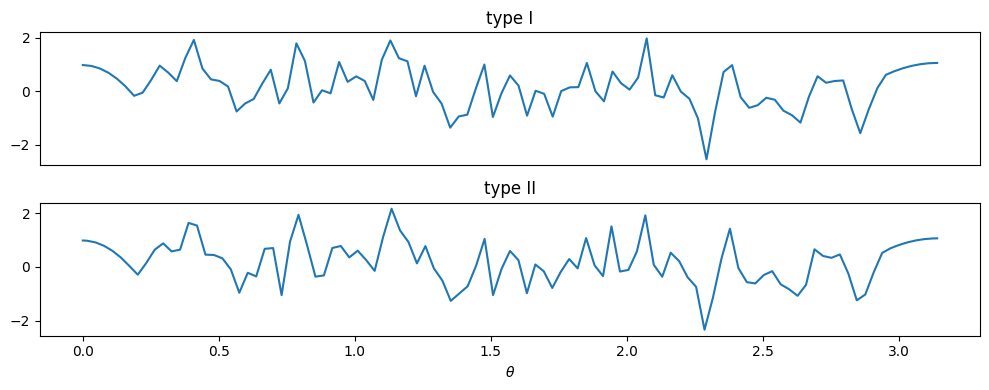

In [5]:
N = len(cos_noise) - 1
fig, axes = pyplot.subplots(2, 1, figsize=(10,4))
axes[0].set_xticks([])
axes[0].plot((np.arange(N+1) * np.pi / N)[::-1], cos_noise)
axes[0].set_title("type I")
axes[1].plot(np.concatenate(([0], (np.arange(N+1) + 0.5) * np.pi/(N+1), [np.pi]))[::-1], cos_noise2);
axes[1].set_xlabel(r'$\theta$')
axes[1].set_title("type II")
pyplot.tight_layout()

This makes the noise at the edges lower frequency, which means it's *harder* to filter and *easier* to *fit*, essentially more difficult to distinguish from legitimate signal.

However, because its variability should be slightly lower at the edges, we should have lower $\Delta y$ errors, which will slightly balance the shrinking $\Delta x$ at the domain edges, making this noise a little bit less fundamentally prone to throw off the derivative.

## Dealing with Noise Using the Fourier Basis

A classic FIR or IIR low-pass filter from Signal Processing, like a Butterworth Filter, works from one end of the signal toward the other "causally", dampening higher-frequencies with only *local*, past and present samples, literally by taking some weighted combination of a few local input values and adding a weighted combination of a few past output values. We analyze its effect on the frequency content of an equispaced signal using the Fourier transform of the filter's impulse response function.

But if we have the whole history of a signal, then there is no need to constrain ourselves locally; we can transform the entire thing to a Fourier basis representation, where modes correspond to frequencies. Hence a common noise removal strategy is:

1. FFT the signal
2. Zero out higher Fourier modes/coefficients
3. IFFT to recover the filtered signal

This achieves an *idealized* lowpass filter, where we get perfect cutoff, as opposed to a causal filter where we instead get power rolloff of, e.g., 20dB/decade.

Let's apply such a filter to a noisy version of the simple periodic singal from [the Fourier notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/fourier.ipynb) and see how well we can recover it and its derivatives.

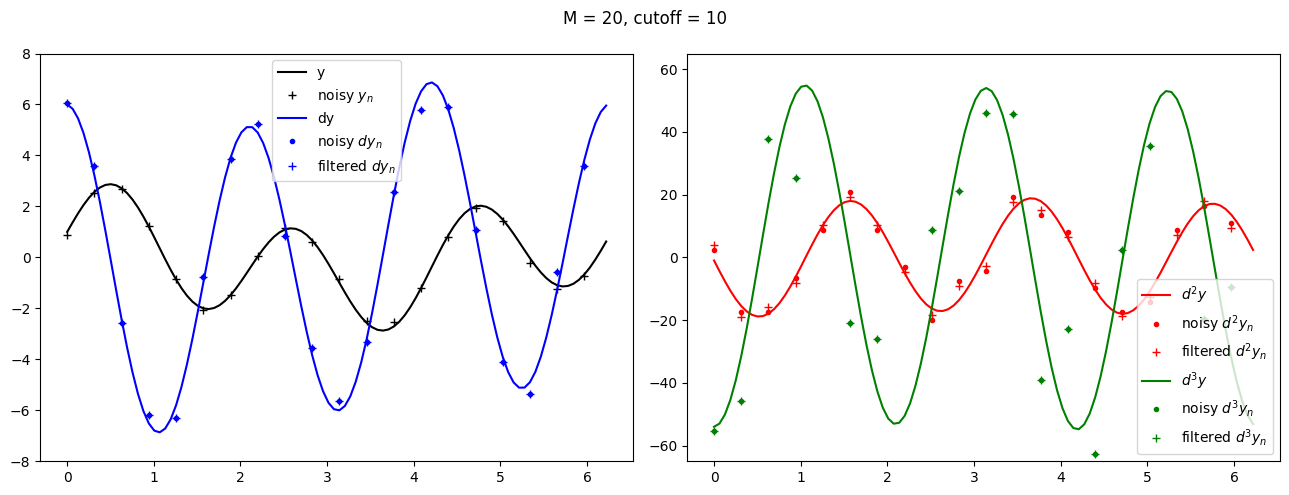

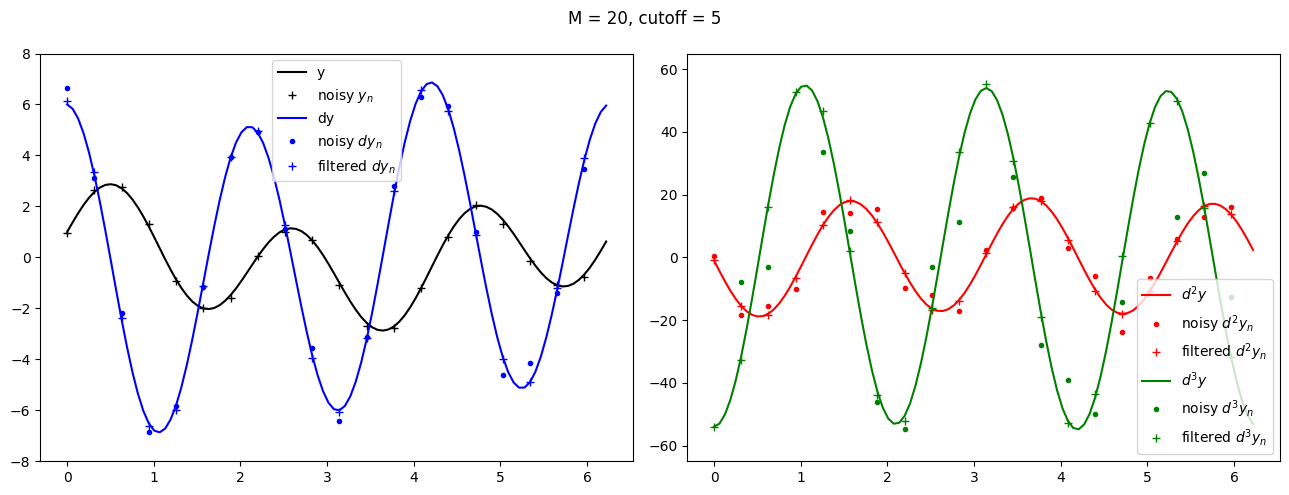

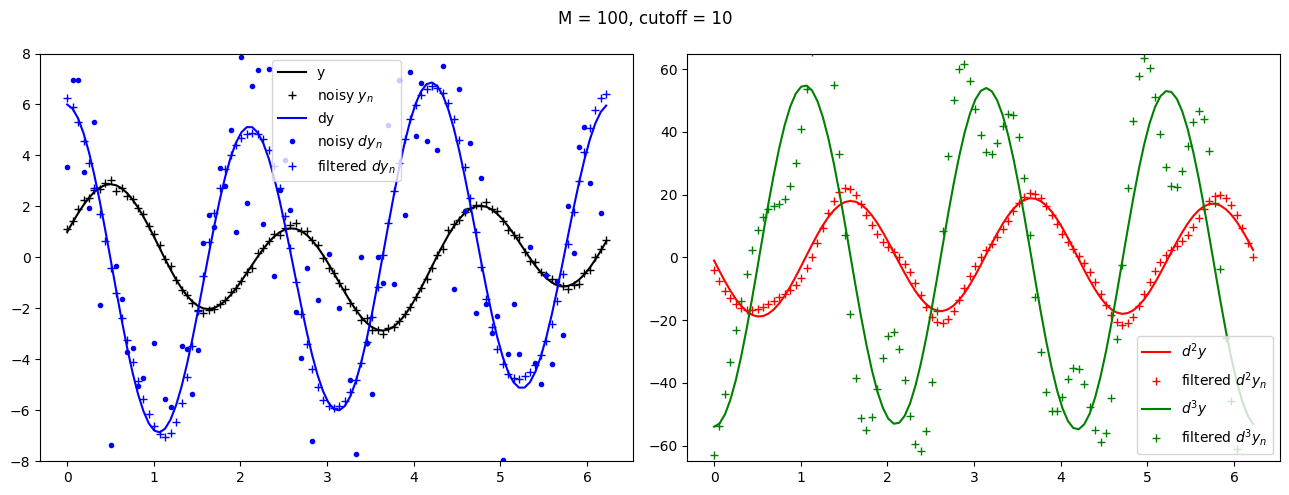

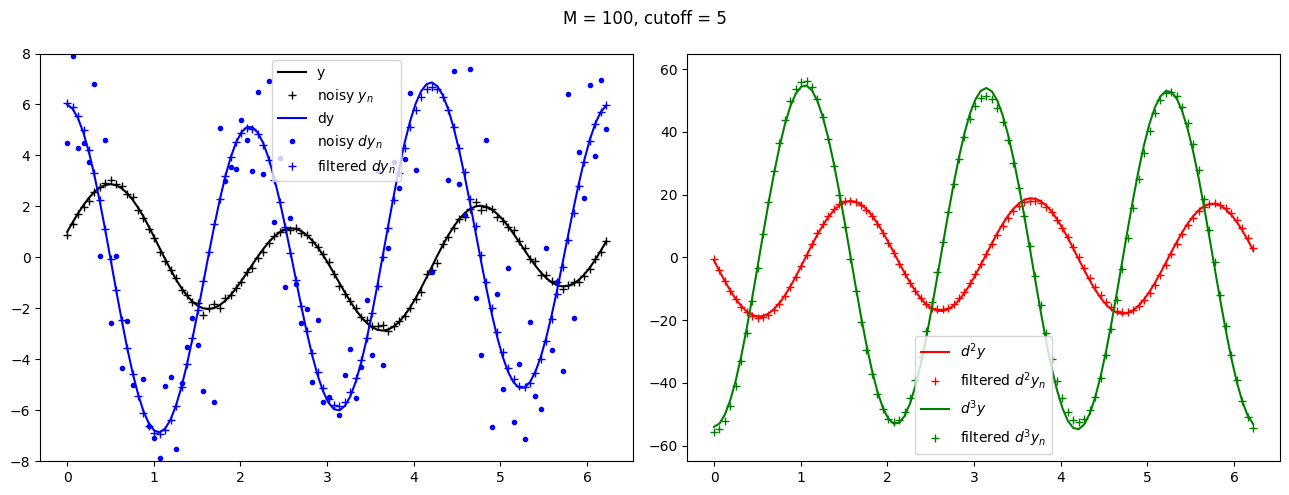

In [6]:
y = lambda th: np.cos(th) + 2*np.sin(3*th)
dy = lambda th: -np.sin(th) + 6*np.cos(3*th)
d2y = lambda th: -np.cos(th) - 18*np.sin(3*th)
d3y = lambda th: np.sin(th) - 54*np.cos(3*th)

th = np.linspace(0, 2*np.pi, 100, endpoint=False)
noise_scale = 0.1

L2_results = pandas.DataFrame(index=['M=20, cutoff=10', 'M=20, cutoff=5', 'M=100, cutoff=10', 'M=100, cutoff=5'], columns=['noisy', 'filtered'])
Linf_results = pandas.DataFrame(index=['M=20, cutoff=10', 'M=20, cutoff=5', 'M=100, cutoff=10', 'M=100, cutoff=5'], columns=['noisy', 'filtered'])

for M in (20, 100):
	for cutoff in (10, 5):
		th_n = np.linspace(0, 2*np.pi, M, endpoint=False)
		y_n = y(th_n)
		y_n_with_noise = y_n + noise_scale*np.random.randn(*th_n.shape) # add in some gaussian noise

		dy_n = [dy(th_n), d2y(th_n), d3y(th_n)]
		dy_n_with_noise = [fourier_deriv(y_n_with_noise, th_n, nu) for nu in range(1, 4)]
		dy_n_with_filter = [fourier_deriv(y_n_with_noise, th_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 4)]

		fig, axes = pyplot.subplots(1, 2, figsize=(13,5))
		fig.suptitle(f"M = {M}, cutoff = {cutoff}")
		axes[0].plot(th, y(th), 'k', label='y')
		axes[0].plot(th_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
		axes[0].plot(th, dy(th), 'b', label='dy')
		axes[0].plot(th_n, dy_n_with_noise[0], 'b.', label=r'noisy $dy_n$')
		axes[0].plot(th_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
		axes[0].set_ylim((-8, 8))
		axes[0].legend()
		axes[1].plot(th, d2y(th), 'r', label=r'$d^2y$')
		if M == 20: axes[1].plot(th_n, dy_n_with_noise[1], 'r.', label=r'noisy $d^2y_n$')
		axes[1].plot(th_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
		axes[1].plot(th, d3y(th), 'g', label=r'$d^3y$')
		if M == 20: axes[1].plot(th_n, dy_n_with_noise[2], 'g.', label=r'noisy $d^3y_n$')
		axes[1].plot(th_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
		axes[1].set_ylim((-65,65))
		axes[1].legend()
		pyplot.tight_layout()

		L2_results.loc[f"M={M}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_noise[nu])}" for nu in range(3)])
		L2_results.loc[f"M={M}, cutoff={cutoff}", 'filtered'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu])}" for nu in range(3)])
		Linf_results.loc[f"M={M}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_noise[nu]))}" for nu in range(3)])
		Linf_results.loc[f"M={M}, cutoff={cutoff}", 'filtered'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu]))}" for nu in range(3)])

In [7]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,noisy,filtered
"M=20, cutoff=10",1: 1.56480946788431562: 13.4375703241832383: 93.52530444576755,1: 1.56480946788431562: 11.4197362216799623: 93.52530444576755
"M=20, cutoff=5",1: 1.53207930027898452: 15.5375316943862233: 84.73837743453807,1: 0.44810274337598562: 1.38218468290018253: 4.884341707860211
"M=100, cutoff=10",1: 28.9755109945940182: 1174.0273806355523: 50041.69618049624,1: 3.20958257338902582: 23.7717610044410463: 184.97207091075344
"M=100, cutoff=5",1: 26.1263578566228322: 1063.8547225548443: 42526.19196040786,1: 1.21159151690507822: 4.5017893880459873: 17.25127576790955


,noisy,filtered
"M=20, cutoff=10",1: 0.73081064240023872: 6.1155210498296963: 35.896367258575275,1: 0.73081064240023872: 4.8121597017615843: 35.896367258575275
"M=20, cutoff=5",1: 0.75707546552947222: 5.920160786584023: 37.58214809120618,1: 0.190999779423416172: 0.52178477336016463: 1.8736042058419784
"M=100, cutoff=10",1: 7.4855382097699152: 287.260451183725143: 12388.124538597818,1: 0.6439839264433422: 4.4806044083745043: 32.416160506225175
"M=100, cutoff=5",1: 9.6442739383986142: 275.99198401046993: 13784.10950378705,1: 0.246297198437835262: 0.88864915428675323: 3.1324411589064987


We can first observe filtering is *way* better than not filtering. The samples blow up so fast in the unfiltered ("noisy") case that it's not even practical to plot them past the first derivative. We can also see unfiltered noise is even more overwhelming when we include more samples, because decreased distance between them increases slopes. But including more samples is better for band separation of noise, so we can better filter the noise with larger $M$, even using the same cutoff frequencies.


## Dealing with Noise Using the Chebyshev Basis

To avert Gibbs phenomenon or achieve better compression (more energy represented in fewer modes), we may prefer to use another basis, like Chebyshev polnomials or PCA modes, to represent a signal. All bases have "lower frequency" and "higher frequency" elements, meaning some modes have fewer transitions between low and high values, and some have more. As in Fourier basis representations, signal energy empirically tends to cluster in lower modes, and noise tends to be scattered across modes.

However, we have to be a bit more conscientious when using non-Fourier modes to filter noise: If a basis function changes frequency over parts of its domain, e.g. like Chebyshev polynomials get steeper toward the edges of $[-1, 1]$, then that basis function will be better at representing high-frequency noise in some regions, and we won't get band-separation quite as cleanly as with the uniform Fourier basis.

Let's try to filter the different types of noise ("measurement" and "process") by keeping different numbers of modes, using different densities of sampling to try for better band separation. We'll use the classic test signal from [the Chebyshev notebook](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev.ipynb). I use both [DCT Type I and II]((https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison_and_extension.ipynb)) to see whether they fare any differently.

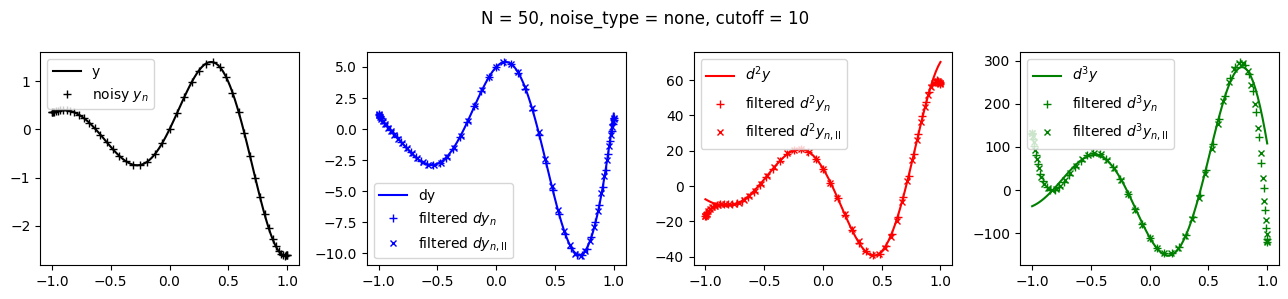

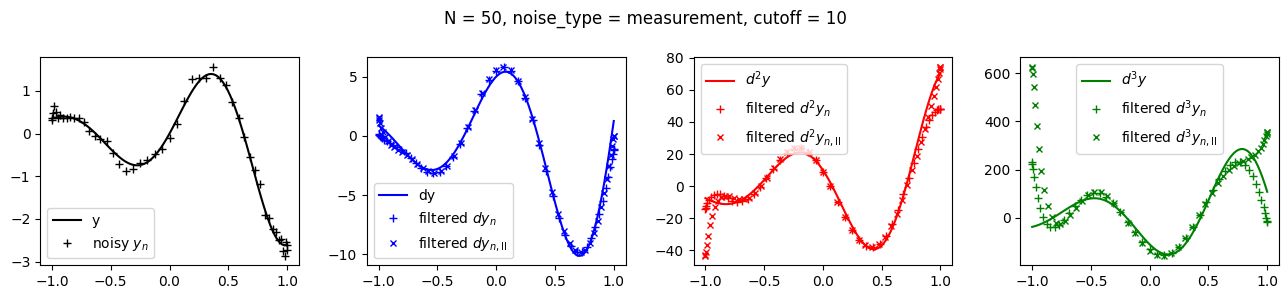

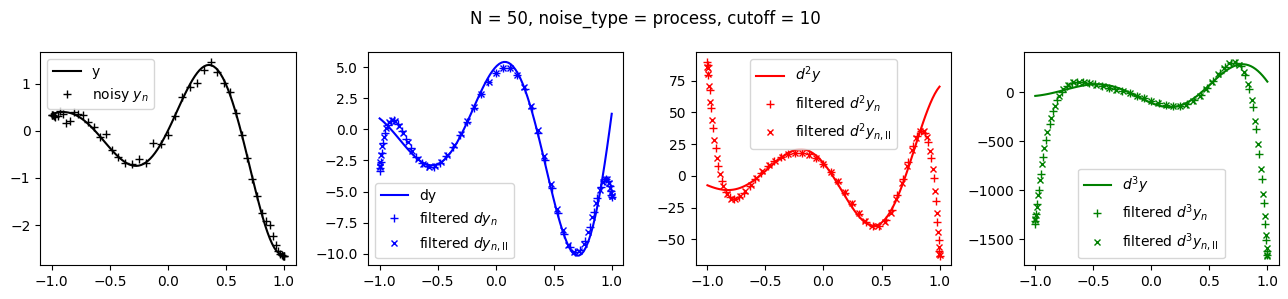

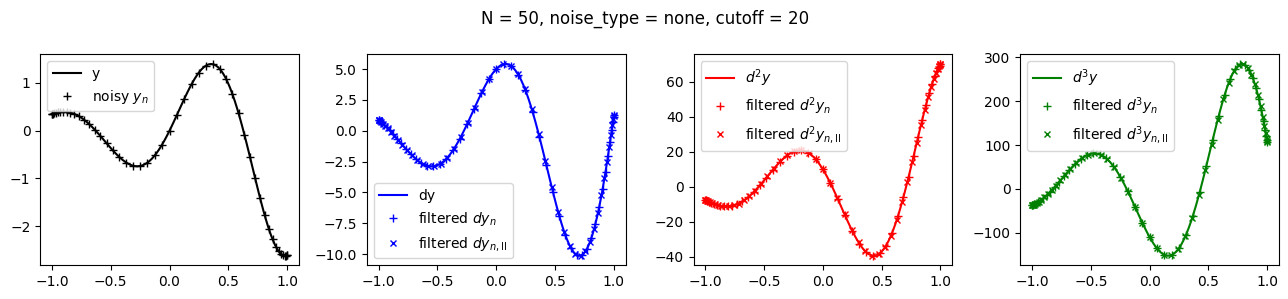

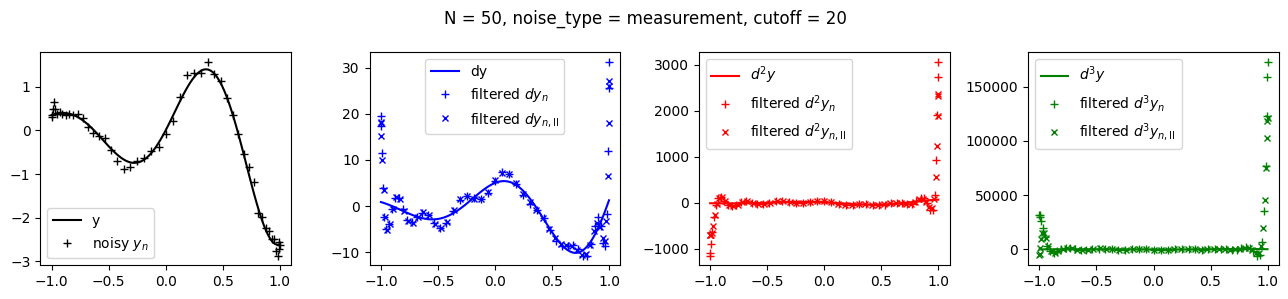

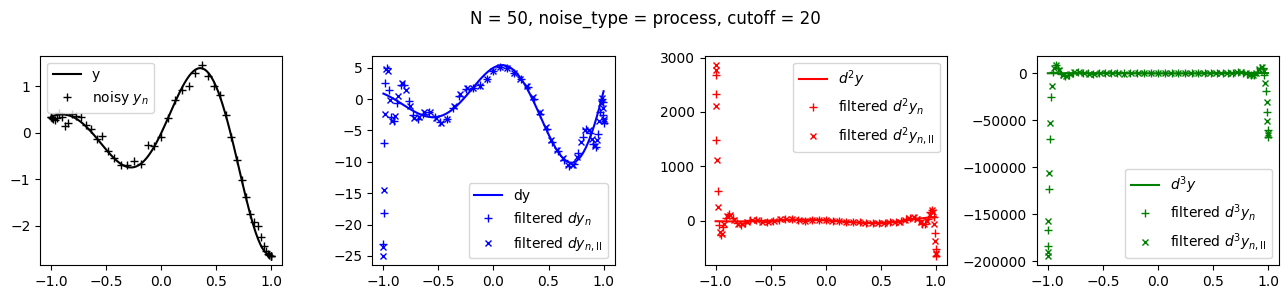

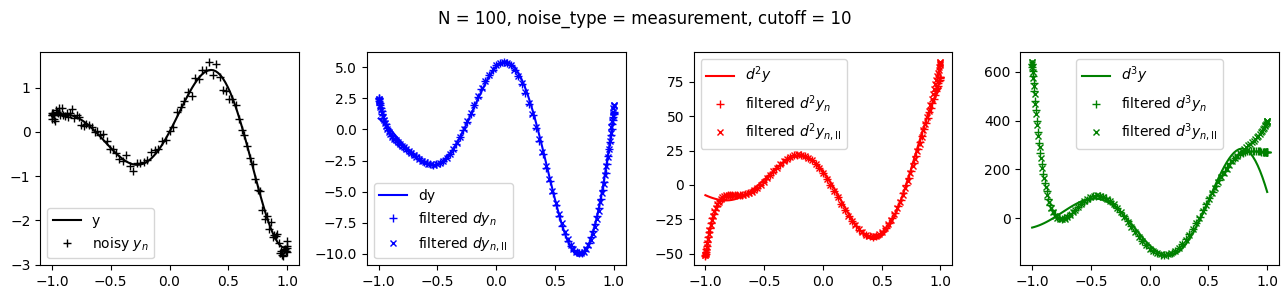

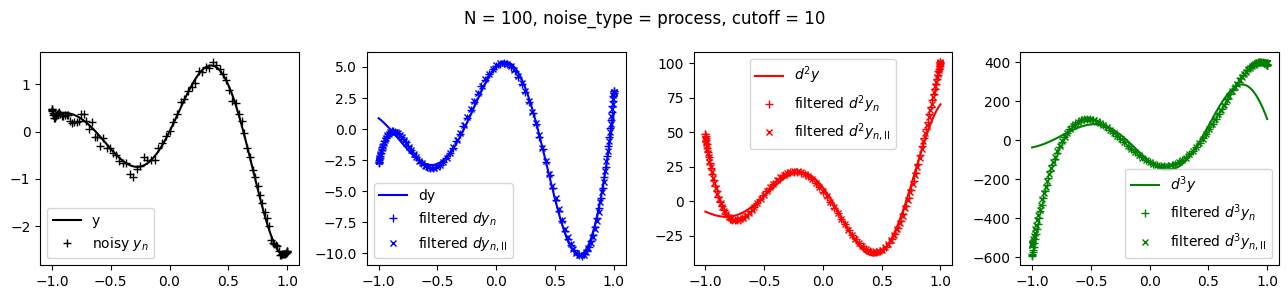

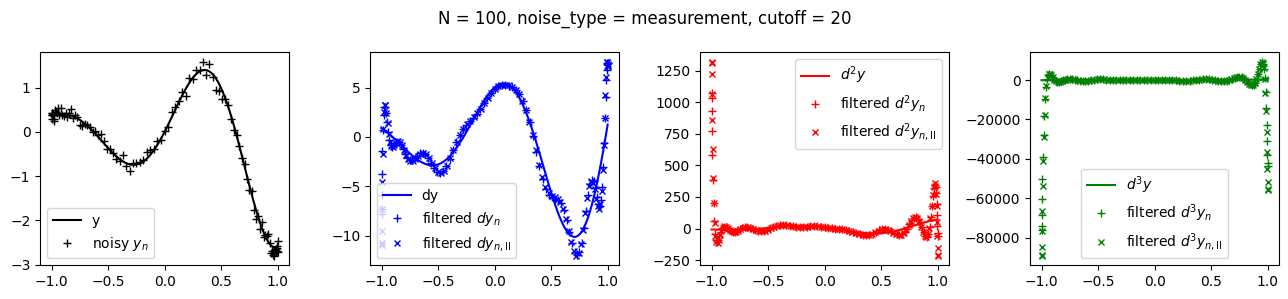

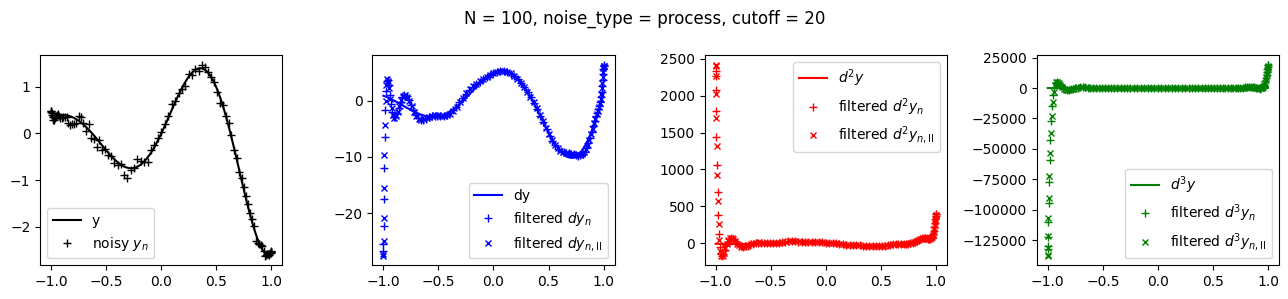

In [8]:
y = lambda x: np.exp(x) * np.sin(5*x)
dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

x = np.linspace(-1, 1, 100)
noise_scale = 0.1

rows = [f"N={N}, cutoff={cutoff}, noise={noise_type}" for N in (50, 100) for cutoff in (10, 20) for noise_type in ('none', 'measurement', 'process') if not (noise_type == "none" and N == 100)]
L2_results = pandas.DataFrame(index=rows, columns=['noisy I', 'noisy II', 'filtered I', 'filtered II'])
Linf_results = pandas.DataFrame(index=rows, columns=['noisy I', 'noisy II', 'filtered I', 'filtered II'])

for N in (50, 100):
	equispaced_noise = np.random.randn(N+3)
	cos_noise, _, cos_noise2, _ = cos_spaced_from_equi(equispaced_noise[1:-1])
	for cutoff in (10, 20):
		x_n = np.cos(np.arange(N+1) * np.pi / N) # length N+1, in keeping with the usage of N in Trefethen.
		x_n2 = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))
		y_n = y(x_n)
		y_n2 = y(x_n2)

		dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]
		dy_n2 = [dy(x_n2), d2y(x_n2), d3y(x_n2), d4y(x_n2)]
		
		for noise_type in ["none", "measurement", "process"]:
			if noise_type == "none" and N == 100: continue # honestly there are too many plots, so let's skip a couple
			noise1 = equispaced_noise[1:-1] if noise_type == "measurement" else cos_noise if noise_type == "process" else 0
			noise2 = equispaced_noise if noise_type == "measurement" else cos_noise2 if noise_type == "process" else 0
			
			y_n_with_noise = y_n + noise_scale*noise1#; y_n_with_noise = savgol_filter(y_n_with_noise, 15, 4)
			y_n2_with_noise = y_n2 + noise_scale*noise2
			
			dy_n_with_noise = [cheb_deriv_via_fourier(y_n_with_noise, x_n, nu) for nu in range(1, 5)] # type: ignore
			dy_n2_with_noise = [cheb_deriv_via_fourier(y_n2_with_noise, x_n2, nu, dct_type=2) for nu in range(1, 5)]

			dy_n_with_filter = [cheb_deriv_via_fourier(y_n_with_noise, x_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 5)]
			dy_n2_with_filter = [cheb_deriv_via_fourier(y_n2_with_noise, x_n2, nu, filter=lambda k: np.abs(k) < cutoff, dct_type=2) for nu in range(1, 5)]
		
			fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
			fig.suptitle(f"N = {N}, noise_type = {noise_type}, cutoff = {cutoff}")
			axes[0].plot(x, y(x), 'k', label='y')
			axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
			#axes[0].plot(x_n2, y_n2_with_noise, 'kx', ms=5, label=r'noisy $y_{n,\text{II}}$')
			axes[1].plot(x, dy(x), 'b', label='dy')
			#if N == 50: axes[1].plot(x_n, dy_n_with_noise[0], 'b.', label=r'noisy $dy_n$')
			axes[1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
			axes[1].plot(x_n2, dy_n2_with_filter[0], 'bx', ms=5, label=r'filtered $dy_{n,\text{II}}$')
			axes[2].plot(x, d2y(x), 'r', label=r'$d^2y$')
			#axes[2].plot(x_n, dy_n_with_noise[1], 'r.', label=r'noisy $d^2y_n$')
			axes[2].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
			axes[2].plot(x_n2, dy_n2_with_filter[1], 'rx', ms=5, label=r'filtered $d^2y_{n,\text{II}}$')
			axes[3].plot(x, d3y(x), 'g', label=r'$d^3y$')
			#axes[3].plot(x_n, dy_n_with_noise[2], 'g.', label=r'noisy $d^3y_n$')
			axes[3].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
			axes[3].plot(x_n2, dy_n2_with_filter[2], 'gx', ms=5, label=r'filtered $d^3y_{n,\text{II}}$')
			for i in range(4): axes[i].legend()
			pyplot.tight_layout()
	
			L2_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'noisy I'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_noise[nu]):.5g}" for nu in range(4)])
			L2_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'noisy II'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n2[nu]-dy_n2_with_noise[nu]):.5g}" for nu in range(4)])
			L2_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'filtered I'] =  '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu]):.5g}" for nu in range(4)])
			L2_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'filtered II'] =  '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n2[nu]-dy_n2_with_filter[nu]):.5g}" for nu in range(4)])
			Linf_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'noisy I'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_noise[nu])):.5g}" for nu in range(4)])
			Linf_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'noisy II'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n2[nu]-dy_n2_with_noise[nu])):.5g}" for nu in range(4)])
			Linf_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'filtered I'] =  '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu])):.5g}" for nu in range(4)])
			Linf_results.loc[f"N={N}, cutoff={cutoff}, noise={noise_type}", 'filtered II'] =  '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n2[nu]-dy_n2_with_filter[nu])):.5g}" for nu in range(4)])

In [9]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,noisy I,noisy II,filtered I,filtered II
"N=50, cutoff=10, noise=none",1: 4.6004e-132: 2.9902e-103: 1.281e-074: 4.0763e-05,1: 8.3742e-132: 3.7241e-103: 2.5985e-074: 0.0012002,1: 0.842692: 29.4793: 594.464: 7876.5,1: 0.915562: 31.6863: 632.794: 8320.1
"N=50, cutoff=10, noise=measurement",1: 148.42: 1.1611e+053: 5.3073e+074: 1.5984e+10,1: 152.072: 629333: 1.5565e+074: 6.2824e+09,1: 5.85152: 58.2573: 643.314: 8916,1: 4.21982: 77.0223: 1583.44: 20209
"N=50, cutoff=10, noise=process",1: 20.9412: 2315.43: 1.6518e+064: 8.196e+08,1: 43.3592: 305073: 1.6066e+074: 5.9442e+09,1: 14.752: 337.063: 48304: 49483,1: 15.4242: 353.033: 5075.74: 52077
"N=50, cutoff=20, noise=none",1: 4.6004e-132: 2.9902e-103: 1.281e-074: 4.0763e-05,1: 8.3742e-132: 3.7241e-103: 2.5985e-074: 0.0012002,1: 3.881e-082: 5.5089e-063: 0.000465764: 0.027401,1: 4.4239e-082: 6.1928e-063: 0.000517074: 0.030376
"N=50, cutoff=20, noise=measurement",1: 148.42: 1.1611e+053: 5.3073e+074: 1.5984e+10,1: 152.072: 629333: 1.5565e+074: 6.2824e+09,1: 50.7432: 4897.93: 2.8589e+054: 1.2194e+07,1: 51.8542: 41833: 2.1893e+054: 9.0786e+06
"N=50, cutoff=20, noise=process",1: 20.9412: 2315.43: 1.6518e+064: 8.196e+08,1: 43.3592: 305073: 1.6066e+074: 5.9442e+09,1: 34.1572: 4041.23: 3.048e+054: 1.5867e+07,1: 41.1672: 4803.43: 3.5332e+054: 1.8105e+07
"N=100, cutoff=10, noise=measurement",1: 914.212: 2.1047e+063: 3.1751e+094: 3.6199e+12,1: 692.942: 7.9445e+053: 1.0562e+094: 1.8178e+12,1: 4.27452: 120.983: 2050.44: 23278,1: 4.58432: 132.793: 22584: 25530
"N=100, cutoff=10, noise=process",1: 53.3582: 369803: 1.1456e+084: 2.2513e+11,1: 193.692: 7.0392e+053: 1.4751e+094: 2.1879e+12,1: 10.8992: 192.513: 2086.74: 14211,1: 11.0012: 189.823: 2006.44: 13061
"N=100, cutoff=20, noise=measurement",1: 914.212: 2.1047e+063: 3.1751e+094: 3.6199e+12,1: 692.942: 7.9445e+053: 1.0562e+094: 1.8178e+12,1: 24.3982: 2182.53: 1.7933e+054: 1.0739e+07,1: 30.4262: 2866.83: 2.2961e+054: 1.3182e+07
"N=100, cutoff=20, noise=process",1: 53.3582: 369803: 1.1456e+084: 2.2513e+11,1: 193.692: 7.0392e+053: 1.4751e+094: 2.1879e+12,1: 52.2682: 4771.13: 2.9022e+054: 1.2706e+07,1: 57.712: 52483: 3.1771e+054: 1.386e+07


,noisy I,noisy II,filtered I,filtered II
"N=50, cutoff=10, noise=none",1: 4.2166e-132: 2.7396e-103: 1.1316e-074: 3.4724e-05,1: 5.3957e-132: 2.2669e-103: 2.0078e-074: 0.00095349,1: 0.374832: 12.233: 229.44: 2850,1: 0.374832: 12.233: 229.44: 2850
"N=50, cutoff=10, noise=measurement",1: 131.272: 1.0779e+053: 4.6257e+074: 1.3186e+10,1: 103.372: 393563: 1.0043e+074: 3.3963e+09,1: 2.39062: 22.4283: 267.964: 3946.2,1: 1.26112: 35.9363: 663.54: 7700.4
"N=50, cutoff=10, noise=process",1: 7.64312: 20083: 1.5047e+064: 7.1179e+08,1: 21.9362: 173463: 8.8103e+064: 3.1645e+09,1: 6.66822: 133.073: 1762.14: 17050,1: 6.60012: 132.953: 1773.14: 17219
"N=50, cutoff=20, noise=none",1: 4.2166e-132: 2.7396e-103: 1.1316e-074: 3.4724e-05,1: 5.3957e-132: 2.2669e-103: 2.0078e-074: 0.00095349,1: 2.3346e-082: 3.1291e-063: 0.000249824: 0.01407,1: 2.3346e-082: 3.1291e-063: 0.000249824: 0.014884
"N=50, cutoff=20, noise=measurement",1: 131.272: 1.0779e+053: 4.6257e+074: 1.3186e+10,1: 103.372: 393563: 1.0043e+074: 3.3963e+09,1: 29.9672: 2988.73: 1.7269e+054: 7.1301e+06,1: 25.9142: 2299.63: 1.206e+054: 4.5359e+06
"N=50, cutoff=20, noise=process",1: 7.64312: 20083: 1.5047e+064: 7.1179e+08,1: 21.9362: 173463: 8.8103e+064: 3.1645e+09,1: 23.972: 2687.93: 1.8364e+054: 8.789e+06,1: 25.8352: 2867.93: 1.941e+054: 9.2491e+06
"N=100, cutoff=10, noise=measurement",1: 842.472: 1.8047e+063: 2.483e+094: 2.565e+12,1: 441.942: 4.7941e+053: 6.469e+084: 1.2297e+12,1: 1.65412: 43.7913: 670.944: 7016.8,1: 1.5762: 43.3133: 677.364: 7187.8
"N=100, cutoff=10, noise=process",1: 15.9692: 363733: 1.0793e+084: 2.0217e+11,1: 151.842: 5.5459e+053: 1.1223e+094: 1.6166e+12,1: 3.57462: 56.1713: 555.024: 3529.3,1: 3.46812: 52.8133: 501.154: 2977.9
"N=100, cutoff=20, noise=measurement",1: 842.472: 1.8047e+063: 2.483e+094: 2.565e+12,1: 441.942: 4.7941e+053: 6.469e+084: 1.2297e+12,1: 8.72942: 1082.13: 759174: 3.7709e+06,1: 11.8192: 1327.13: 891584: 4.3129e+06
"N=100, cutoff=20, noise=process",1: 15.9692: 363733: 1.0793e+084: 2.0217e+11,1: 151.842: 5.5459e+053: 1.1223e+094: 1.6166e+12,1: 27.5412: 2340.93: 1.3239e+054: 5.4542e+06,1: 28.412: 2426.13: 1.3759e+054: 5.679e+06


As with the Fourier case, we see that filtering is usually preferable to not filtering, although we are not doing as well in general. Maybe surprisingly, `cheb_deriv` has about equal trouble in the presence of process noise and measurement noise, at least when we filter out more modes. But filtering out fewer modes (higher cutoff) *usually* hurts performance less in the case of process noise.

A key realization from this experiment is that using type I or type II points makes very little difference, despite all my [hopes](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/dct_types_comparison_and_extension.ipynb) and [dreams](https://github.com/pavelkomarov/spectral-derivatives/issues/13). In light of this, and because supporting type II points adds confusion to the user interface and is somewhat cumbersome to add to [the code](https://github.com/pavelkomarov/spectral-derivatives/blob/main/specderiv/specderiv.py) when using the [Chebyshev series derivative rule](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/alternative_chebyshev_derivative_methods.ipynb), since endpoints no longer need to be treated specially, I have chosen to exclusively use the DCT-I going forward.

Notice that in the Chebyshev basis, we appear to need *more* modes to fit the function itself, because it's asymmetrical and more complicated, and this becomes a tradeoff with noise filtration. If we use 20 modes, we can represent this function no problem, but if we use 10, then *even in the noiseless case* we really can't, at least not at the edges. The interpolation ends up just *slightly* less steep than we need, because we're leaving off higher modes that could help us complete its representation, and this throws of subsequent derivatives ever more. But if we use 20 modes in the presence of noise, the noise slips through, especially affecting the interpolation at the edges of the domain, causing extra wobbles that kill us. I've tried to brainstorm ways around this in [Issue #14](https://github.com/pavelkomarov/spectral-derivatives/issues/14) without success. The Chebyshev basis fundamentally can't accomplish noise separation across the whole domain as uniformly as the Fourier basis.

I also tried combining a Savitzky-Golay prefilter with the Chebyshev method, but it often hurts performance, only some times improves it by a small margin, and does not solve the systematic blowup at the edges of the domain.

## Comparison with Savitzky-Golay + Gaussian Smoothing

It's worth comparing the above to a local method.

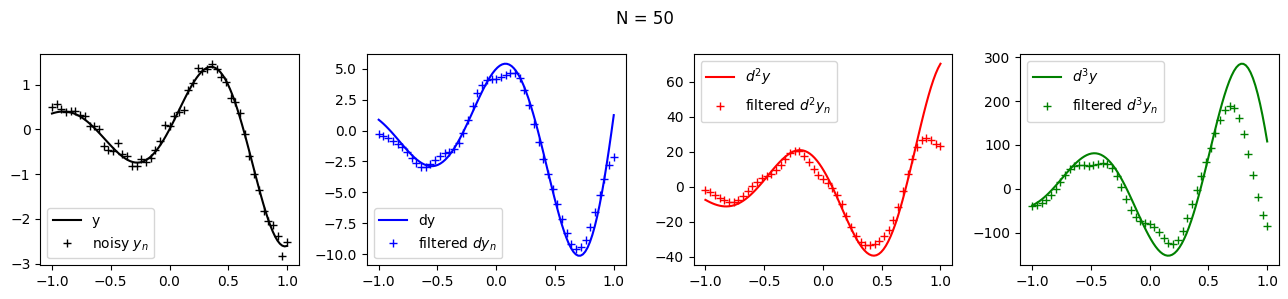

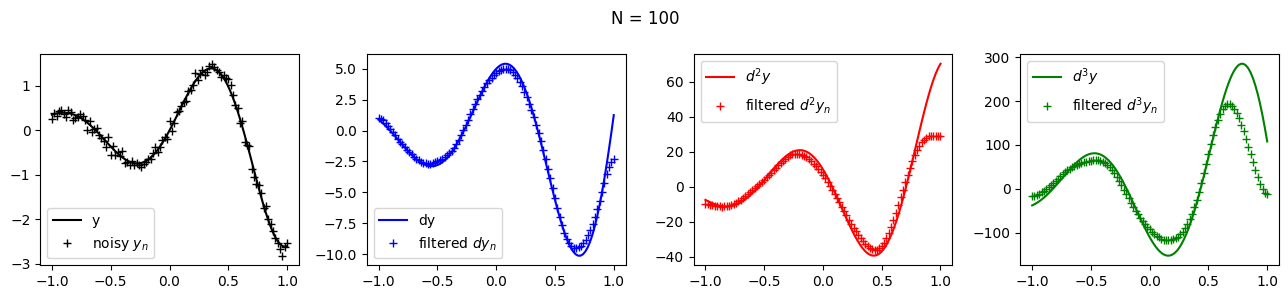

In [10]:
L2_results = pandas.DataFrame(index=['N=50', 'N=100'], columns=['savgoldiff'])
Linf_results = pandas.DataFrame(index=['N=50', 'N=100'], columns=['savgoldiff'])

for N in (50, 100):
	x_n = np.linspace(-1, 1, N+1)
	dx = x_n[1] - x_n[0]

	y_n = y(x_n)
	dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]

	y_n_with_noise = y_n + noise_scale*np.random.randn(*x_n.shape)
	#dy_n_with_filter = [savgol_filter(y_n_with_noise, 11, 4, deriv=nu)/dx**nu for nu in range(1,5)]
	dy_n_with_filter = [savgoldiff(y_n_with_noise, dx, (3, N//5+1, N//5+1))[1]] # Floris' function only does one derivative at a time
	for nu in range(2, 5):
		dy_n_with_filter.append(savgoldiff(dy_n_with_filter[-1], dx, (3,  N//5+1, N//5+1))[1])

	fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
	fig.suptitle(f"N = {N}")
	axes[0].plot(x, y(x), 'k', label='y')
	axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
	axes[1].plot(x, dy(x), 'b', label='dy')
	axes[1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
	axes[2].plot(x, d2y(x), 'r', label=r'$d^2y$')
	axes[2].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
	axes[3].plot(x, d3y(x), 'g', label=r'$d^3y$')
	axes[3].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
	for i in range(4): axes[i].legend()
	pyplot.tight_layout()
    
	L2_results.loc[f"N={N}", 'savgoldiff'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu]):.5g}" for nu in range(4)])
	Linf_results.loc[f"N={N}", 'savgoldiff'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu])):.5g}" for nu in range(4)])

In [11]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,savgoldiff
N=50,1: 5.37082: 77.2543: 547.694: 2201.5
N=100,1: 5.66622: 91.0973: 640.274: 3083.7


,savgoldiff
N=50,1: 3.35692: 47.1433: 233.844: 789.21
N=100,1: 3.59032: 41.0983: 192.014: 1058.3


It's also quite hard to make this work, and in many cases/with many parameter choices the 1st derivative fit does significantly worse than the spectral method. But this method suffers less from systematic blowup at the domain edges as we go to higher derivatives.

## Epilogue: Chebyshev Edge Blowup Still Occurs with Uniform Sampling

Since the [series-based Chebyshev derivative rule](https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/alternative_chebyshev_derivative_methods.ipynb) allows sampling at any points in the domain, albeit at much greater computational cost ($O(N^3)$ rather than $O(N \log N)$), it's worth an experiment to see whether edge blowup is improved by not shrinking $\Delta x$ at the edges of the domain.

It turns out Chebyshev polynomials have a harder time fitting and filtering the domain edges in this case too, indicating this effect is not purely due to the cosine-spaced sampling:

/Users/pavel/Code/spectral-derivatives/notebooks/../specderiv/specderiv.py:50: UserWarning: Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`.
			`cheb_deriv` using chebfit() and chebval() under the hood, which costs O(N^3) instead of O(N log N).
  warn("""Your function is not sampled for the DCT-I, i.e. `t_n = np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`.
/usr/local/lib/python3.13/site-packages/numpy/polynomial/chebyshev.py:1626: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.13/site-packages/numpy/polynomial/chebyshev.py:1626: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.13/site-packages/numpy/polynomial/chebyshev.py:1626: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)
/usr/local/lib/python3.

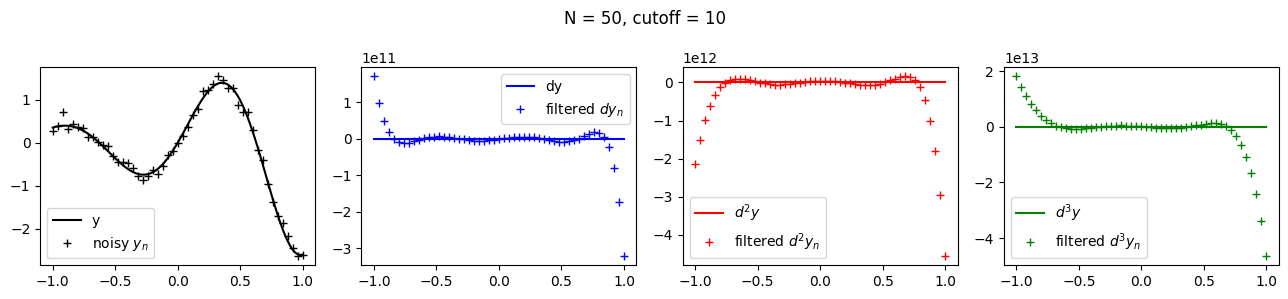

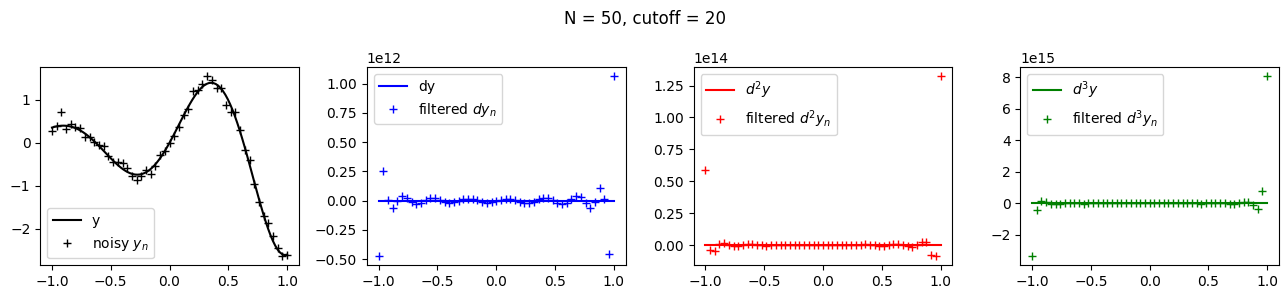

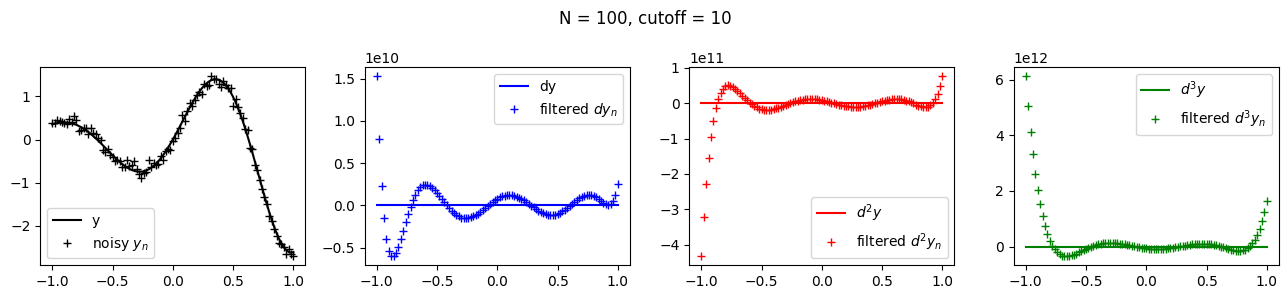

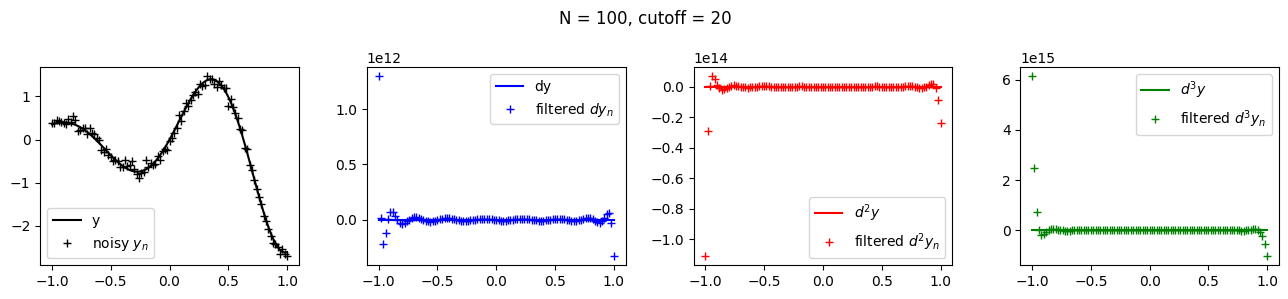

In [12]:
rows = [f"N={N}, cutoff={cutoff}" for N in (50, 100) for cutoff in (10, 20)]
L2_results = pandas.DataFrame(index=rows, columns=['noisy', 'filtered'])
Linf_results = pandas.DataFrame(index=rows, columns=['noisy', 'filtered'])

for N in (50, 100):
	equispaced_noise = np.random.randn(N+1)
	for cutoff in (10, 20):
		x_n = np.linspace(-1, 1, N+1, endpoint=True) # length N+1, in keeping with the usage of N in Trefethen.
		y_n = y(x_n)

		dy_n = [dy(x_n), d2y(x_n), d3y(x_n), d4y(x_n)]
		y_n_with_noise = y_n + noise_scale*equispaced_noise

		dy_n_with_noise = [cheb_deriv(y_n_with_noise, x_n, nu) for nu in range(1, 5)]
		dy_n_with_filter = [cheb_deriv(y_n_with_noise, x_n, nu, filter=lambda k: np.abs(k) < cutoff) for nu in range(1, 5)]
	
		fig, axes = pyplot.subplots(1, 4, figsize=(13,3))
		fig.suptitle(f"N = {N}, cutoff = {cutoff}")
		axes[0].plot(x, y(x), 'k', label='y')
		axes[0].plot(x_n, y_n_with_noise, 'k+', label=r'noisy $y_n$')
		axes[1].plot(x, dy(x), 'b', label='dy')
		axes[1].plot(x_n, dy_n_with_filter[0], 'b+', label=r'filtered $dy_n$')
		axes[2].plot(x, d2y(x), 'r', label=r'$d^2y$')
		axes[2].plot(x_n, dy_n_with_filter[1], 'r+', label=r'filtered $d^2y_n$')
		axes[3].plot(x, d3y(x), 'g', label=r'$d^3y$')
		axes[3].plot(x_n, dy_n_with_filter[2], 'g+', label=r'filtered $d^3y_n$')
		for i in range(4): axes[i].legend()
		pyplot.tight_layout()
	
		L2_results.loc[f"N={N}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_noise[nu]):.5g}" for nu in range(4)])
		L2_results.loc[f"N={N}, cutoff={cutoff}", 'filtered'] =  '<br/>'.join([f"{nu+1}: {np.linalg.norm(dy_n[nu]-dy_n_with_filter[nu]):.5g}" for nu in range(4)])
		Linf_results.loc[f"N={N}, cutoff={cutoff}", 'noisy'] = '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_noise[nu])):.5g}" for nu in range(4)])
		Linf_results.loc[f"N={N}, cutoff={cutoff}", 'filtered'] =  '<br/>'.join([f"{nu+1}: {np.max(np.abs(dy_n[nu]-dy_n_with_filter[nu])):.5g}" for nu in range(4)])

In [13]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,noisy,filtered
"N=50, cutoff=10",1: 9.1838e+122: 2.0431e+153: 3.1295e+174: 3.9509e+19,1: 4.2965e+112: 6.5398e+123: 7.1693e+134: 5.8313e+14
"N=50, cutoff=20",1: 9.1838e+122: 2.0431e+153: 3.1295e+174: 3.9509e+19,1: 1.2915e+122: 1.4564e+143: 8.7918e+154: 3.7668e+17
"N=100, cutoff=10",1: 5.7938e+132: 1.3234e+173: 1.6247e+204: 1.3862e+23,1: 2.4762e+102: 6.409e+113: 1.0659e+134: 1.1798e+14
"N=100, cutoff=20",1: 5.7938e+132: 1.3234e+173: 1.6247e+204: 1.3862e+23,1: 1.3725e+122: 1.1826e+143: 6.7742e+154: 2.9e+17


,noisy,filtered
"N=50, cutoff=10",1: 7.9075e+122: 1.7573e+153: 2.6886e+174: 3.3894e+19,1: 3.2222e+112: 4.5685e+123: 4.6502e+134: 3.4904e+14
"N=50, cutoff=20",1: 7.9075e+122: 1.7573e+153: 2.6886e+174: 3.3894e+19,1: 1.0644e+122: 1.3233e+143: 8.0677e+154: 3.4433e+17
"N=100, cutoff=10",1: 5.4778e+132: 1.2559e+173: 1.5412e+204: 1.3142e+23,1: 1.5297e+102: 4.3248e+113: 6.1352e+124: 5.7301e+13
"N=100, cutoff=20",1: 5.4778e+132: 1.2559e+173: 1.5412e+204: 1.3142e+23,1: 1.2981e+122: 1.1134e+143: 6.1395e+154: 2.5137e+17


Once again, using a filter tends to be better than not using one, but the blowup is in fact much *worse* than when using DCT-I-compatible points.

Interestingly, even in the presence of no noise, the fit gets markedly worse at the domain edges as $N$ increases and as the derivative order increases. This is a fundamental problem covered in [On the Errors Incurred Calculating Derivatives Using Chebyshev Polynomials](https://www.sciencedirect.com/science/article/pii/0021999192902743), related to the the fact "Tight coupling between coefficients enables propagation of errors from high frequency to low frequency modes." Essentially, any error in the value of a higher-order Chebyshev coefficient will affect [every-other lower-order coefficient](https://scicomp.stackexchange.com/questions/44939/chebyshev-series-derivative-in-terms-of-coefficients) in the derivative's series, and because lower-orders' coefficients are used to evaluate ever-lower-orders' coefficients [iteratively/recursively](https://github.com/numpy/numpy/blob/v2.2.0/numpy/polynomial/chebyshev.py#L874-L961), the errors compound in a really nasty way. When found by least squares instead of by DCT, the coefficients start off significantly less accurate, and less accurate coefficients cause larger errors where the polynomials are most sensitive, i.e. steepest, which is the domain edges.